# Evaluating GAN Performance on Generated Dog Imagery: Comparing Minimax and Wasserstein Loss Functions

by Everett Lewark & Austin Youngren

## Introduction

For this term project, we wanted to pursue a topic of interest that was not covered in the CS345 course: Generative Adversarial Networks.

Initially developed in 2014, the Generative Adversarial Network (GAN) is a form of generative model that operates based on two models trained simultaneously: a generator attempts to create output data from noise, while a discriminator learns to tell real, ground-truth training data apart from data created by the generator (“Introduction”). The GAN architecture is widespread enough that tutorials exist for the popular PyTorch and TensorFlow machine learning libraries ("Deep Convolutional Network").

Due to the amount of informative websites and resources geared towards Generative Adversarial Networks, we never found ourselves lacking information in guiding us to a successful model. The DCGAN tutorial provided in the TensorFlow documentation proved particularly helpful, and was the basis for much of the code in this notebook. With that being said, it was also easy to be overwhelmed by the amount of insight out there. Some of these resources had a tendency to lead us in the wrong direction with our hyperparameters for our earlier model implementation due to the various types of GAN networks.

Though we consistently collaborated via teams, Everett focused on tuning the Wasserstein implementation while Austin focused on tuning the Minimax implementation. For work which impacted both implementations, Everett focused on tuning issues caused by code structure and learning rate, while Austin focused on tuning other hyperparameter values and visual presentation of the data. We both worked on resource gathering and typed sections of the document. Additionally, we individually followed the TensorFlow GAN tutorial to start ("Deep Convolutional Network").

The primary hyperparameters that were adjusted most frequently through all versions of our model were batch sizes (range of 8 to 64), optimizers (Adam and RMSprop), learning rate values (Adam: 1e-4, 1e-5, 2e-4 and RMSprop: 5e-5, 4e-4), batch normalization(with and without), number of training epochs (range of 50 to 2000), and the loss functions (MiniMax and Wasserstein).

When adjusting the hyperparameters associated with the convolution layers, we explored Conv2D as a stand alone, Conv2DTranspose as a standalone. and a mixture of Conv2D with UpSampling2D. For the mixture of Conv2D with Upsampling2D, we further explored the interpolation types of bilinear, nearest, gaussian, bicubic, area, and lanczos3.

Additionally, we adjusted various characteristics of the input data such as the image size (28x28, 32x32, & 64x64), cropping (with and without image stretching), noise dimension (100, 128, & 256), and image shuffling(shuffling every epoch or only shuffling at the start of training).

When it came to GAN evaluation, the general consensus within our resources was that the best method of evaluation was through qualitative means. Various quantitative techniques can be used, an example being Frechet Inception Distance Scoring (Brownlee, "How to Implement Frechet"), but we did not pursue these due to time constraints.


In [1]:
import os
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, activations, regularizers
import time

from IPython import display

2023-12-08 03:38:48.700600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 03:38:48.700678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 03:38:48.712955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 03:38:48.805303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 03:38:52.424560: W tensorflow/compiler/tf2

## Dataset: Stanford Dogs

The [Stanford Dogs Dataset](https://www.tensorflow.org/datasets/catalog/stanford_dogs) consists of 20,580 images taken from the larger ImageNet dataset. These images are broken down into 120 dog breed categories, and bounding box annotations describe where dogs appear within each image (Khosla, Aditya, et al.). This dataset is primarily intended for training classifier models, but it is also suitable for training a generative model. Because it depicts one type of subject (dogs), a generative model can learn patterns that are consistent among dogs in the dataset. Additionally, because it is a dataset containing images of animals, it will be clear if the generator makes mistakes, since the images will appear unsettling to the viewer.

Issues that the dataset may present in training are inconsistency in dog sizing within the images, images that don’t contain the dog in its entirety, different background coloring that may cause issues of distinguishing the dog from the rest of the image, and the presence of other objects or non-canine body parts. Additionally, the difference of breeds may cause confusion for the models ability to generate. On the other hand, it may improve the models' ability to generate unique imagery. 


In [2]:
import tensorflow_datasets as tfds

dataset = tfds.load("stanford_dogs")

IMAGE_SIZE = 64

@tf.function
def process_image(data):
    image = data['image']
    boxes = data['objects']['bbox']

    new_box = correct_box(tf.shape(image), boxes[0])
    image_cropped = tf.image.crop_and_resize([image], [new_box], [0], [IMAGE_SIZE, IMAGE_SIZE])[0]

    # normalize image pixels to be between [-1, 1]
    image_norm = (image_cropped - tf.reduce_min(image_cropped))
    image_norm = image_norm / tf.reduce_max(image_norm)
    image_scaled = image_norm * 2 - 1

    return image_scaled

@tf.function
def correct_box(img_shape, box):
    """ Reshape rectangular bounding boxes to be square """
    shape_float = tf.cast(img_shape, tf.dtypes.float32)
    abs_height = (box[2] - box[0]) * shape_float[0]
    abs_width = (box[3] - box[1]) * shape_float[1]
    
    difference = abs_height - abs_width
    
    if difference > 0:
        # Keep the uppermost part of a vertical box (usually containing the dog's face)
        height_offset = difference / shape_float[0]
        return box + [0, 0, -height_offset, 0]
    elif difference < 0:
        # Take the middle section of a horizontal box,
        # since we don't know which direction the dog is facing 
        width_offset = -difference / (2 * shape_float[1])
        return box + [0, width_offset, 0, -width_offset]
    else:
        return box

train_images = dataset['train'].concatenate(dataset['test']).map(process_image) #.filter(is_roughly_bw)
train_images = train_images.shuffle(buffer_size=train_images.cardinality(), reshuffle_each_iteration=True) # from tf.Dataset.shuffle docs

2023-12-08 03:38:58.602062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 03:38:58.854200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 03:38:58.854556: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In order to properly use this dataset, we have to perform some preprocessing. The images have varying dimensions, so they must be resized to a consistent shape in order to train our model. Additionally, many images contain other complex features such as people, with the dog being a small portion of the image. To make the task easiest for our GAN, Everett wrote code to crop the images to focus on the dogs. Because the bounding-box rectangles of the dogs are not square, the crop boundary must be squared out in order to ensure the dogs are not stretched and distorted. Otherwise, dogs seen from the side are squeezed horizontally to fit in a square, and dogs seen from the front are squashed vertically. Since we are performing unsupervised learning, we combine the train and test sets from the Stanford Dogs Dataset together as our train set for the model. We also normalize the image brightness to make the data more regular and shuffle the images to add variation during the training process; this is particularly important for the Wasserstein GAN, where the generator is trained on fewer batches.


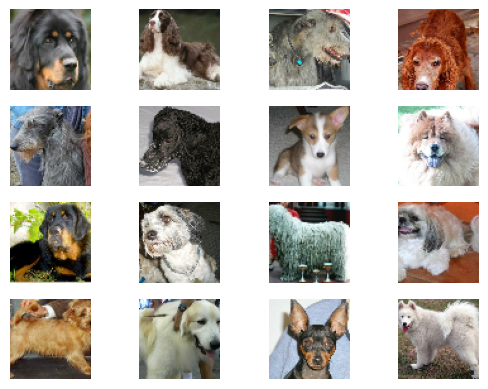

In [12]:
import matplotlib.pyplot as plt

preview_rows = 4
for i, data in enumerate(train_images.take(preview_rows ** 2)):
    plt.subplot(preview_rows, preview_rows, i+1)
    plt.imshow((data.numpy() + 1) / 2)
    plt.axis('off')

The images are also grouped into batches, which allow for faster training time. However, using batches that are too large can backfire and cause problems such as overfitting (Lheureux). In the case of the Stanford Dogs Dataset, one blog post suggested smaller batch sizes would work better, so we ended up going in that direction (Mittal).


In [15]:
BATCH_SIZE=16
train_dataset = train_images.batch(BATCH_SIZE)

## Generator

As mentioned earlier, the generator model is responsible for producing the output images. The Tensorflow GAN tutorial, which both Everett and Austin completed on their own time, uses functions like this to define each model within the GAN ("Deep Convolutional"). However, this model has been modified from the one in that tutorial.

In [3]:
def make_generator_model(transpose=True):
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=True, input_shape=(256,)))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Reshape([8,8,512]))
    assert model.output_shape == (None, 8, 8, 512) # None is batch size

    add_conv_layer(model, 256, upscale=True, transpose=transpose)
    assert model.output_shape == (None, 16, 16, 256)

    add_conv_layer(model, 128, upscale=True, transpose=transpose)
    assert model.output_shape == (None, 32, 32, 128)
    
    add_conv_layer(model, 64, upscale=True, transpose=transpose)
    assert model.output_shape == (None, 64, 64, 64)
    
    add_conv_layer(model, 3, upscale=False, transpose=False, final=True)
    assert model.output_shape == (None, 64, 64, 3)
    return model

### Generator: Architecture

This particular generator model uses an architecture described by Maynard-Reid in a PyImageSearch article, which Austin ran across while researching GANs. Everett worked to reimplement the architecture here, because a 64x64 GAN would have a better shot at recreating details of the dogs than a 28x28 one as was described in the original TensorFlow DCGAN tutorial.

The generator itself is a convolutional neural network composed of multiple layers. Dense layers are typical fully-connected feedforward layers, as described in lecture. Convolutional layers, on the other hand, apply a given number of convolutional filters to their input, thereby creating multiple result images (“tf.keras.layers.Conv2D”). Depending on our settings, this generator uses either plain 2D convolution layers, or 2D transposed-convolution (deconvolution) layers.

We have also tried different combinations of additional layers as part of this model. When present, BatchNormalization layers apply a form of standardization, but adjust their correction factors only during the training phase. When run in inference mode, a BatchNormalization layer applies the offset and multiplication factor it learned during training (“tf.keras.layers.BatchNormalization”). LeakyReLU layers also transform the data that passes through, but instead use an activation function that lowers the magnitude of values less than zero based on the alpha hyperparameter (“tf.keras.layers.LeakyReLU”).


In [4]:
def add_conv_layer(model, n, upscale=False, final=False, transpose=True):
    conv_options = {
        'padding': 'same',
        #'use_bias': True,
        'activation': 'tanh' if final else None,
        #'kernel_regularizer': 'l2',
        #'bias_regularizer': 'l2',
    }
    kernel_size = (4, 4)
    
    if transpose:
        strides = (2, 2) if upscale else (1, 1)
        model.add(layers.Conv2DTranspose(n, kernel_size, strides=strides, **conv_options))
    else:
        if upscale:
            model.add(layers.UpSampling2D(size=(2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(n, kernel_size, **conv_options))
        
    if not final:
        #model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

def make_l2():
    return regularizers.L2()

As described in the DCGAN tutorial, we can preview the output from an untrained generator, which results in the following ("Deep Convolutional Network").

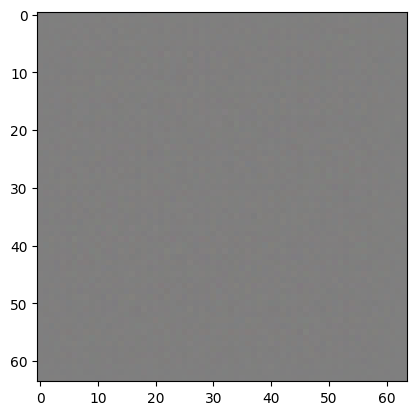

In [57]:
generator = make_generator_model()

noise = tf.random.normal([1, 256])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :] + 1) / 2)

## Discriminator

The discriminator is another convolutional neural network that classifies whether images are real or fake. Rather than deconvolution layers, this one uses plain convolution layers with stride 2, so at each strided convolution the image dimensions are halved. Dropout layers help reduce overfitting by randomly replacing a portion of values passing through them with zero (“tf.keras.layers.Dropout”). Everett took the discriminator layout here from the same PyImageSearch article by Maynard-Reid, but modified it to incorporate a parameter for a kernel constraint, which is used for the Wasserstein GAN later in the notebook. The upsampling modification from earlier was deemed unnecessary here because the end-user does not see any images output from the discriminator, so artifacts are less consequential.

In [5]:
def make_discriminator_model(const=None):
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
        input_shape=[64, 64, 3], kernel_constraint=const))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 32, 32, 64)

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_constraint=const))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 16, 16, 128)

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_constraint=const))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 8, 8, 128)

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, kernel_constraint=const))

    return model

Once again, the tutorial demonstrates how the output from the discriminator can be computed ("Deep Convolutional Network"). In this case it isn't sure whether it's looking at a real image or not, as one would expect from an untrained network.

In [59]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.0019794]], shape=(1, 1), dtype=float32)


## Training

Below are some of the hyperparameters used for both models:

* `EPOCHS` are the number of times the model is trained on the dataset.

* `noise_dim` is the amount of noise used for image generation.

The other two variables are not hyperparameters, but serve as important pieces within the models' output format:

* `num_examples_to_generate` controls the number of output images for each epoch.

* `seed` an array of noise values and is input to the generator each training epoch to generate the preview output images. These noise values remain the same from epoch to epoch so that gradual improvements in the GAN can be observed.

In [6]:
EPOCHS = 1000
noise_dim = 256

num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### GAN Class train_step Method

The `train_step` method for our GAN model (once again based on the TensorFlow DCGAN tutorial) gets called on each individual batch of dog images ("Deep Convolutional Network"). It generates a random vector to use as a seed for the generator, and then computes loss function values from the discriminator’s output on generated images and the training images. The gradients of these loss functions are then used to update the generator and discriminator models. The GradientTape objects record gradients for any calculations performed within the `with` block, and allow them to be applied to the model weights in this manner ("tf.GradientTape"). Everett wrapped the `train_step` method in a class so that it can easily be used with the differing Minimax and Wasserstein models.

In [7]:
class GAN:
    def __init__(self):
        self.generator_loss_epoch = []
        self.discriminator_loss_epoch = []

    @tf.function
    def train_step(self, images, batch_num):
        train_generator = ((batch_num % self.generator_interval) == 0)
        
        noise = tf.random.normal([tf.shape(images)[0], noise_dim])
    
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            generated_images = self.generator(noise, training=True)
    
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
    
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
    
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    
        if train_generator:
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
    
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
    
        return gen_loss, disc_loss

### Training Process Per Epoch

The `train` method is the code method that pulls the program together, and evolved from the initial TensorFlow tutorial ("Deep Convolutional Network"). We start by creating a method of saving checkpoints of our runs, so we can pick up where we left off if anything were to cause the program to abruptly stop. After setting up the checkpoint, we start epoch iterations. Each epoch iteration will loop through all batches of the dataset for training and collect loss values for the generator and discriminator from each batch. After the batch iterations, we take the mean loss of all batches, respectively to the generator and discriminator, and store those values in an array to use later for plot visualization. 

Once calculated, the output of the previous epoch is cleared for presenting the updated data of the current epoch, which includes 16 images, the time it took to run the epoch, the learning rate of the generator and discriminator, and the plot showing mean loss per epoch. This section also saves a progress checkpoint every 15 epochs. 

After all epochs have finished, there is one last clear to the output for a cleaner presentation of the finished run. This final output presents the image data and the plot of the final product without epoch time or learning rate data.


In [8]:
def train(dataset, epochs, model):
    model.checkpoint_dir = './training_checkpoints'
    model.checkpoint_prefix = os.path.join(model.checkpoint_dir, "ckpt")
    model.checkpoint = tf.train.Checkpoint(generator_optimizer=model.generator_optimizer,
                                 discriminator_optimizer=model.discriminator_optimizer,
                                 generator=model.generator,
                                 discriminator=model.discriminator)

    for epoch in range(epochs):
        start = time.time()

        gen_loss_batch = []
        disc_loss_batch = []

        for batch_num, image_batch in enumerate(dataset):
            gen_loss_value, disc_loss_value = model.train_step(image_batch, tf.constant(batch_num, dtype=tf.dtypes.int32))
            
            gen_loss_batch.append(gen_loss_value)
            disc_loss_batch.append(disc_loss_value)

        model.generator_loss_epoch.append(np.mean(gen_loss_batch))
        model.discriminator_loss_epoch.append(np.mean(disc_loss_batch))
        
        display.clear_output(wait=True)
        print("Time for epoch {} is {} sec".format(epoch + 1, time.time()-start))
        
        print("Learning rates: generator {}, discriminator {}".format(*model.get_lr()))
        
        generate_and_save_images(model, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            model.checkpoint.save(file_prefix = model.checkpoint_prefix)

        plot_loss(model)
        

    display.clear_output(wait=True)
    generate_and_save_images(model, epochs, seed)
    
    plot_loss(model, True)

### Image saving
By saving repositories of the generated images, we provide a way to qualitatively assess and compare each model for narrowing hyperparameter values for the model. These images can be used to create gifs for visualizing performance evolution which can ease and shorten the process of side-by-side comparison. This feature was included in the GAN tutorial, and was critical for evaluating the quality of our results and tuning our model hyperparameters ("Deep Convolutional Network").


In [9]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.generator(test_input, training=False)

    fig = plt.figure(figsize=(7, 7))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')

    plt.savefig('{}_image_at_epoch_{:04d}.png'.format(model.name, epoch))
    plt.show()

### Plotting Loss Functions

Austin added this code to generate a learning-curve plot of the models' loss functions. Plotting the loss of the generator and discriminator will allow us to see any pitfalls that may take place. This method of visualizing the loss will allow detection of non-convergence, any de-stabilization of loss values in both the generator and discriminator, and generator/discriminator performance for every epoch performed. 

Symptoms of non-convergence will show increasing values of loss, where the generator and discriminator function lines move away from each other. De-stabilization of the generator or discriminator can be seen when their respective function lines show heavy amounts of sporadic oscillation after a period of stable loss values. Additionally, this will allow us to compare the model performance to previous versions of the model for fine tuning the hyperparameters that best fit the data set.


In [10]:
def plot_loss(model, save=False):
    plt.figure(figsize=(7, 7))
    plt.plot(range(len(model.generator_loss_epoch)), model.generator_loss_epoch, label = "Generator Loss")
    plt.plot(range(len(model.discriminator_loss_epoch)), model.discriminator_loss_epoch, label = "Discriminator Loss")
    plt.title(model.name + " Loss Per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Batch Loss")
    plt.legend()
    
    if save:
        plt.savefig("loss_epochs_{}_{}.png".format(len(model.generator_loss_epoch), model.name))
    plt.show()

## Minimax GAN

### Minimax GAN description 

The minimax loss function is one of the earliest loss functions utilized in the training of Generative Adversarial Networks, making an appearance in the 2014 paper [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) by Ian J. Goodfellow, et al. This loss function is calculated through applying cross entropy between the imported image dataset's distributions and the generator's produced image set distributions. The goal is for the generator to minimize the loss, while the discriminator works to maximize the loss. The generator is fed only fake data, (i.e., noise) and determines what to generate in the next epoch based on the discriminator's scoring of its current output. The discriminator does this by classifying the generated images as real or fake after being trained on both fake data (i.e., generated noise) and real data (i.e., The Stanford Dog Dataset). 

Further formula insight can be seen in [Google's Advanced Courses for GAN](https://developers.google.com/machine-learning/gan/loss) and further explanation of functionality can be found at [neptune.ai's page on GAN loss functions](https://neptune.ai/blog/gan-loss-functions).

The minimax loss function can produce decent output, but it is not without its problems. Training a GAN that utilizes the minimax loss function can be quite frustrating due to non-convergence, mode collapse, diminished gradients, and generator-discriminator balance, all of which can be tracked to the model’s sensitivity to its hyperparameters. 

* **Non-convergence** is an issue where the generator and discriminator loss values de-stabilize and never converge (“Common Problems”). This issue is often caused by having a learning rate value that is too high and can be identified via images that look like static (Tanay).
  
* **Vanishing Gradients** are a sign that your discriminator is performing higher than your generator, leaving the generator with few options for improvement (“Common Problems”). This causes the generator gradient to become close to zero, resulting in no improvement (Dwivedi).
  
* **Mode Collapse** can be identified via repetition of imagery in the generated image set. It too can be caused by having a high learning rate and can be a symptom of non-convergence in loss. Mode Collapse can also be a symptom of Diminished gradients in later stages of training. Due to the discriminator being overly successful, the generator will choose images that are passing the discriminator's tests for multiple output samples within a generation (Tanay).

In our work we found that the minimax loss function is a great way to get to know the hyperparameters and their effects on the models.


In [66]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

class Minimax(GAN):
    def __init__(self):
        self.generator = make_generator_model()
        self.discriminator = make_discriminator_model(None)

        self.lr = 1e-4
        
        self.generator_optimizer = tf.keras.optimizers.Adam(self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(self.lr)
        self.name = "Minimax"
        self.generator_interval = 1
        super().__init__()

    def get_lr(self):
        return self.lr, self.lr
    
    @tf.function
    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    @tf.function
    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

In [67]:
minimax = Minimax()

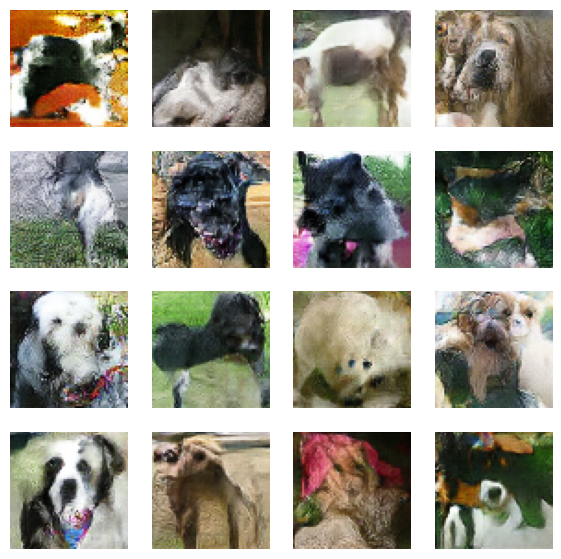

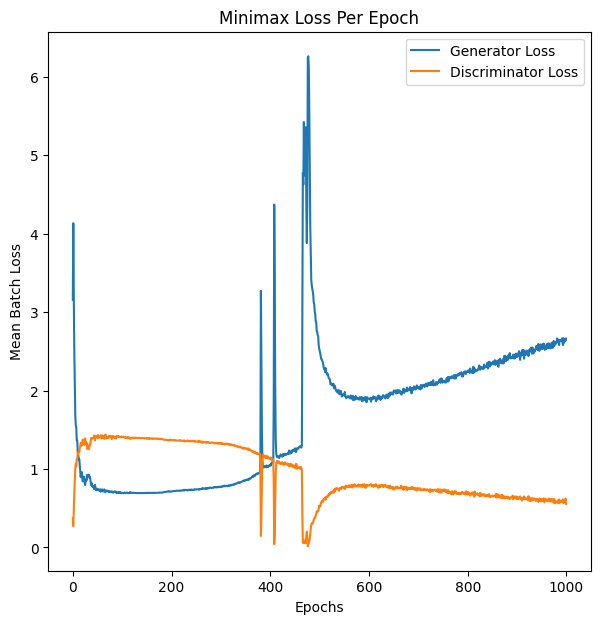

In [68]:
train(train_dataset, EPOCHS, minimax)

The state of the model can be saved and loaded using checkpoints, which are saved periodically by the training loop ("Deep Convolutional Network"). This allows pausing a training session to resume later, or storing the state in case of a crash. We did not end up taking full advantage of this functionality, however.

In [69]:
minimax.checkpoint.restore(tf.train.latest_checkpoint(minimax.checkpoint_dir))

In case we want to retrieve an output image that was saved at a particular epoch, the tutorial once again has us covered ("Deep Convolutional Network"):

In [70]:
def display_minimax_image(epoch_no):
    return PIL.Image.open('{}_image_at_epoch_{:04d}.png'.format(minimax.name, (epoch_no)))

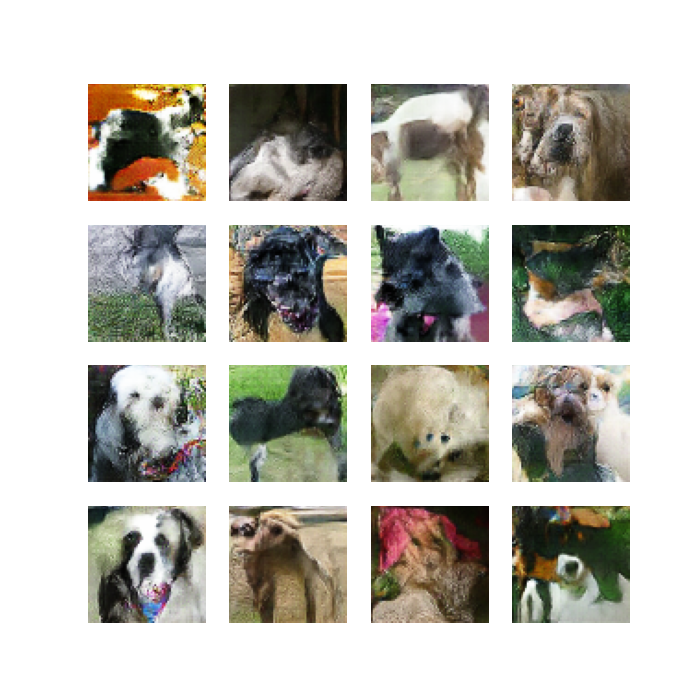

In [71]:
display_minimax_image(EPOCHS)

### Minimax results
Implementing our first model of minimax yielded highly questionable results and introduced us to almost every pitfall you could find when training a GAN model, especially mode collapse and non-convergence. To correct this we changed many hyperparameters but did not see true improvement until Austin increased our image size from 28x28 to 32x32 and our noise value from 100 to 128. In changing these values, we saw less static in the generated images along with less appearance of mode collapse which brought clarity to another underlying issue with our data processing, image stretching. Once Everett adjusted the cropping method, the generated imagery improved further, leaving minimal need for adjusting input characteristics with the exception of fine tuning what image size and noise dimensions would fit best. These changes were the biggest aid in lessening the occurrence of mode collapse and vanishing gradients in the model.

When finalizing which image size and noise dimension worked best, the goal was to find a balance between the clarity of the generated images and the run time.  Austin tested image sizes of 32x32, 64x64, and 128x128. He found that 128x128 was too taxing of hardware and produced epoch times of 30 seconds or more when combined with larger valued hyperparameters. This did not fare well with epoch values of 500 or more. 64x64 ended up being the best pick for image size due to the clarity it provided and the epoch times ranging from 10 to 20 second, varying in this range depending on which hyperparameters were being utilized.

Then, due to the improvement seen in the generated images from the small increase of the noise dimension of 100 to 128, Austin wanted to try increasing the noise dimension to 256. This increase produced some of the best generated images over the course of the project and became a constant value through each variation of the model.

Starting from the first model, we had frequently tried different batch sizes ranging from 8 to 64. The smaller this value was, the longer each epoch took to train due to the increase in the amount of batch exchanges that occurred. Austin found that a batch size of 16 produced the best quality of images for the minimax and consistently worked with that value, while Everett preferred a batch size of 32 for the shortened epoch time. 

Alongside fine tuning batch size, we both played with the number of Epochs used in training; where we played with values ranging from 20 to 2000 to obtain rough estimates of where underfitting started to dissipate and where overfitting began. We found that epoch values of 500 gave enough image distinction, and 1000 showed minimal signs of image distortion due to overfitting. Thus, we used 500, 1000, and values in between for testing other hyperparameter values involving convolution.

We did not have time to fine tune the learning rate as much as we hoped for this model. For the ADAM optimizer, we tested values of 1e-4, 1e-5, 2e-4, and 2e-5 but did not see any drastic changes in model performance. Additionally, Austin tried utilizing the RMSprop optimizer used in the Wasserstein model and again found minimal significance in the change.

Where we saw the next significant change was when we applied different types of convolution. Convolution as a stand alone did not yield any great value when applied to the minimax model, in fact it worsened the quality of the output images. When applying Upsampling to the convolution, we saw a mixed bag of results that was dependent on the type of interpolation utilized. The best results we obtained when utilizing UpSampling2D with Conv2d was when we used bilinear interpolation, with nearest neighbor interpolation being a close second; other interpolation options yielded poor results. The other method that yielded the most success, and had performance on par with bilinear interpolation was the use of deconvolution. This method performed well in its image generation but presented sporadic results in its loss trend. Austin wanted to pursue what happened with this further but ran out of time.

## Wasserstein

### Wasserstein GAN Description
The Wasserstein GAN model attempts to address some shortcomings of Minimax. The minimax model is sometimes subject to mode collapse, where the output space of the model becomes constrained to a limited subset of the training examples ("Common Problems"). For instance, the model may become fixated on generating a specific dog species and pose. Another large problem with minimax models is their susceptibility to vanishing gradients. Because the discriminator outputs a binary classification value indicating whether an image is real or fake, the generator can become stuck if the discriminator gets too far ahead and correctly classifies all fake images ("Common Problems").
In order to address the latter problem, WGAN modifies the discriminator slightly. Instead of classifying images as real or fake, it instead outputs a realness score. This altered discriminator, termed the critic, has a loss function that attempts to maximize the difference in score between real and fake images (“Loss Functions”). Because it no longer matters if the critic gets far ahead of the generator, the critic is actually trained more often than the generator. The original Wasserstein GAN paper describes a process where some number N samples are taken from the dataset and used to train the critic, and then one training step is done for the generator afterward (Arjovsky et al.). For our implementation, Everett approximated the random-sampling behavior described in the original paper by randomly shuffling the dataset every epoch and then only training the generator on batches whose index is divisible by N.


In [11]:
# taken from Machine Learning Mastery Wasserstein tutorial
from tensorflow.keras import constraints, backend

# clip model weights to a given hypercube
class ClipConstraint(constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

### Wasserstein ClipConstraint

The weights in the GAN model are clipped using a custom constraint, the code for which was obtained from a Machine Learning Mastery WGAN tutorial (Brownlee, "How to Develop Wasserstein"). This is a simple method designed by the original WGAN creators to enforce Lipschitz continuity on the model outputs (Arjovsky et al.). In other words, the authors aimed to constrain the slope to remain below a specific threshold (“Lipschitz continuity”). However, they describe this clipping method as “clearly terrible” due to factors like its propensity to cause vanishing gradients (Arjovky et al.). A later paper, titled “Improved Training of Wasserstein GANs,” proposed an alternative WGAN-GP architecture with a less objectionable Lipschitz constraint, and if we were to continue this project further, we would likely try that architecture (Gulrajani et al.).


In [12]:
from tensorflow.keras.optimizers import schedules
import math

class Wasserstein(GAN):
    def __init__(self):
        self.generator = make_generator_model()
        self.discriminator = make_discriminator_model(ClipConstraint(0.01))

        self.name = "Wasserstein"
        self.generator_interval = 3
        self.lr = 5e-5
        #self.initial_lr = 4e-4
        #self.end_lr = 5e-5
        #self.decay_epochs = 200
        #self.batches_per_epoch=train_dataset.cardinality() 
        
        #self.generator_lr = self.make_decay(math.ceil(self.batches_per_epoch / self.generator_interval))
        #self.discriminator_lr = self.make_decay(self.batches_per_epoch)
        self.generator_optimizer = tf.keras.optimizers.experimental.RMSprop(self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.experimental.RMSprop(self.lr)
        super().__init__()

    def make_decay(self, steps_per_epoch):
        return schedules.PolynomialDecay(
            initial_learning_rate=self.initial_lr, end_learning_rate=self.end_lr,
            decay_steps=steps_per_epoch * self.decay_epochs
        )

    def get_lr(self):
        #return (
        #    self.generator_lr(self.generator_optimizer.iterations).numpy(),
        #    self.discriminator_lr(self.discriminator_optimizer.iterations).numpy()
        #)
        return 5e-5, 5e-5

    @tf.function
    def discriminator_loss(self, real_output, fake_output):
        return tf.reduce_mean([-real_output, fake_output])

    @tf.function
    def generator_loss(self, fake_output):
        return tf.reduce_mean(-fake_output)

In this case, the loss functions for the critic and generator are computed using the means of the critic outputs. These functions are once again based on the Machine Learning Mastery tutorial, but Everett modified them to take the same parameters as the Minimax loss (Brownlee, "How to Develop Wasserstein"). This model also has the option of using a custom curve for the learning rate over time (see the commented-out code), but a fixed value was chosen for this particular run. Were the code to be uncommented, it would apply a linear function to the learning rate so that it changes from an initial value of 4e-4 to a final value of 5e-5 by epoch 200 ("tf.keras.optimizers.schedules.PolynomialDecay").


In [13]:
wass = Wasserstein()

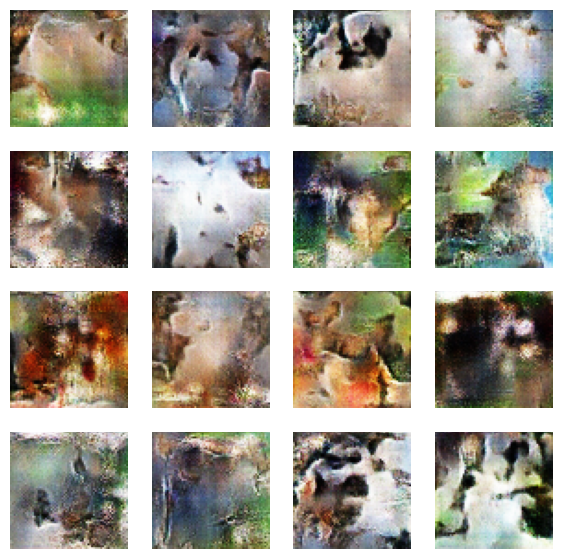

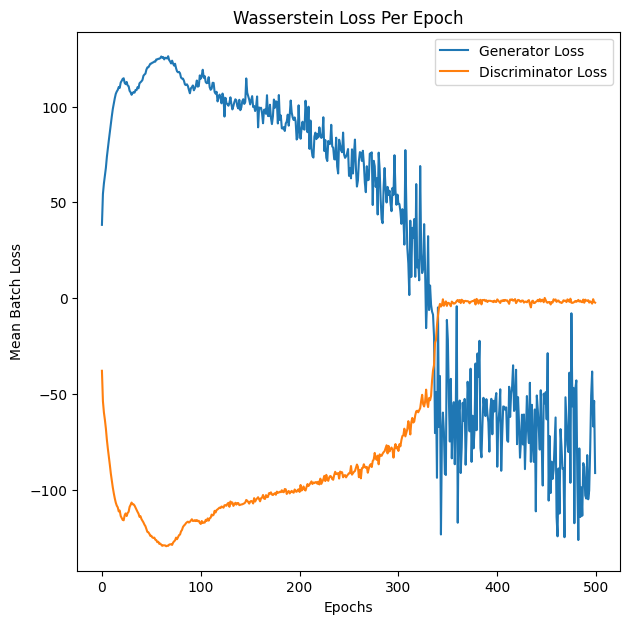

In [16]:
train(train_dataset, 500, wass)

Due to time constraints, this Wasserstein run was limited to 500 epochs. Not much benefit was observed from extending the training time further than 500 in the past. Since the critic performance dropped sharply past 300 epochs, it's possible the output quality worsened past that point. As alluded earlier with Minimax, we can view the past output at an earlier epoch to see what performance was like before the critic was overwhelmed:

In [19]:
def display_wass_image(epoch_no):
    return PIL.Image.open('{}_image_at_epoch_{:04d}.png'.format(wass.name, epoch_no))

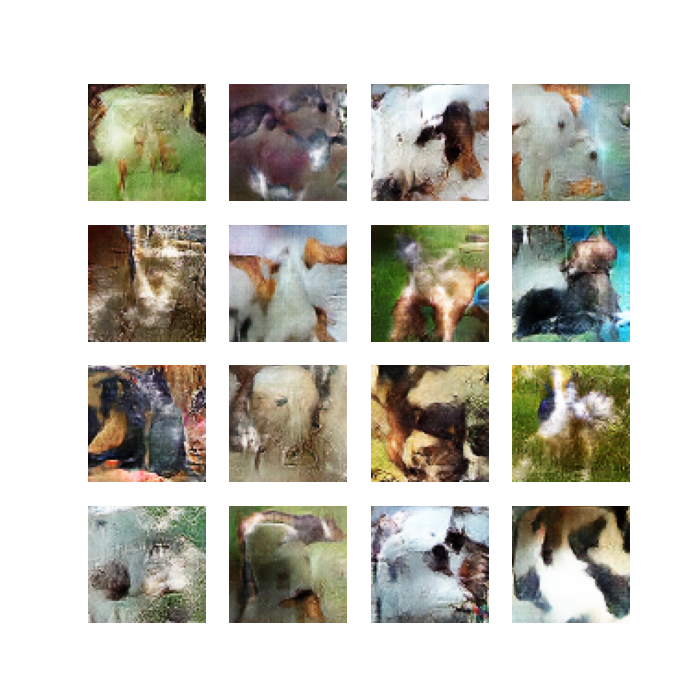

In [22]:
display_wass_image(300)

Comparing these images tells us that yes indeed, the generated image quality worsened after the critic stopped being able to tell fake and real images apart.

### Wasserstein Results

When tuning hyperparameters for the Wasserstein GAN, Everett found that while higher learning rates decrease training time, the learning rate should be set low enough that the critic can outpace the generator during the initial stages. When the critic loss became too close to zero, then the generator often wouldn't converge. The generator seemed to be able to learn simpler features like fur with this change, and sometimes hints of facial features, but still struggled to render the shape of the dogs overall. Running for very large numbers of epochs (>500) would sometimes result in the appearance of features like eyes and ears, but not reliably. He also experimented with varying the learning rate over the course of training, using a higher one during the first 200 epochs to learn the larger-scale shapes, and lowering it during later epochs in order to learn fine details. Though this sped up the learning process for those initial epochs, model performance did not seem much better than with either of the two learning rates on their own. When this feature is used, it results in an interesting pattern on the loss graph, where the loss functions for both models diverge sharply at epoch 200 before beginning to converge again gradually. At large epochs, the training process seemed to slow significantly, which suggested that vanishing gradients may be at play. It is possible that another architecture like WGAN-GP may perform better.

Overall, with the tweaks Austin made to the Minimax parameters, that model seemed to perform better than the Wasserstein GAN. The performance of the Wasserstein model was further limited this run due to tweaks made to shared hyperparameters with Minimax, like batch size and noise dimension, so in the future it may be good to split these properties up so they can be changed per model. Earlier runs with differing batch sizes and noise feature counts were able to achieve slightly better Wasserstein results.

## Conclusion

We are proud of the level of performance we were able to get from the model, though we wish we had more time to implement a quantitative evaluation method such as Frechet Inception Distance to further improve performance. This would have required time we did not have to load and test another model along with refactoring our code. 

Though our notebook borrows much of its implementation and layout from the Tensorflow DCGAN tutorial, Everett made some modifications to better allow experimentation while maximizing code reuse. For instance, he created the Wasserstein and Minimax classes, which allowed common GAN behavior to be shared while also incorporating each model’s unique features (such as loss functions). Additionally, Austin provided a way to visualize and track model performance that was not found in the tutorial and aided in Everett’s changes.

We found working on this project to be very enjoyable despite our initial struggles and only wish we had more time to pursue testing methods, execute further hyperparameter evaluation, and improve model performance.


## Bibliography 

- Agrawal, Tanay. “GANs Failure Modes: How to Identify and Monitor Them.” *neptune.ai,* 7 Aug. 2023, https://neptune.ai/blog/gan-failure-modes. Accessed 7 Dec. 2023.
- Arjovsky, Martin, et al. “The Wasserstein GAN.” *arXiv,* 6 Dec. 2017, https://arxiv.org/abs/1701.07875. Accessed 7 Dec. 2023.
- Brownlee, Jason. “How to Develop a Wasserstein Generative Adversarial Network (WGAN) From Scratch.” *Machine Learning Mastery,* 18 Jan. 2021, https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/. Accessed 7 Dec. 2023.
- Brownlee, Jason. "How to Implement the Frechet Inception Distance (FID) for Evaluating GANs." Machine Learning Mastery, 11 Oct. 2019, https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/. Accessed 8 Dec 2023.
- “Common Problems.” Google. *Google for Developers,* 18 July 2022, https://developers.google.com/machine-learning/gan/problems. Accessed 7 Dec. 2023.
- "Deep Convolutional Generative Adversarial Network." *TensorFlow Core,* 5 Nov. 2023,
www.tensorflow.org/tutorials/generative/dcgan. Accessed 8 Dec 2023.
- Dwivedi, Harshit. “Understanding GAN Loss Functions.” *neptune.ai,* 29 Aug. 2023, https://neptune.ai/blog/gan-loss-functions. Accessed 7 Dec. 2023.
- Gulrajani, Ishaan, et al. “Improved training of Wasserstein GANs.” *arXiv,* https://arxiv.org/abs/1704.00028. Accessed 7 Dec. 2023.
- “Introduction.” Google. *Google for Developers,* 18 July 2022, https://developers.google.com/machine-learning/gan.
- Khosla, Aditya, et al. “Novel dataset for Fine-Grained Image Categorization.” First Workshop on Fine-Grained Visual Categorization, IEEE Conference on Computer Vision and Pattern Recognition, Stanford University, June 2011, http://people.csail.mit.edu/khosla/papers/fgvc2011.pdf. Accessed 8 Dec. 2023.
- Lheureux, Adil. “How to maximize GPU utilization by finding the right batch size.” *Paperspace,* 2022, https://blog.paperspace.com/how-to-maximize-gpu-utilization-by-finding-the-right-batch-size/. Accessed 7 Dec. 2023.
- “Lipschitz continuity.” *Wikipedia,* https://en.wikipedia.org/wiki/Lipschitz_continuity. Accessed 7 Dec. 2023.
- “Loss Functions.” Google. *Google for Developers,* 18 July 2022, https://developers.google.com/machine-learning/gan/loss. Accessed 7 Dec. 2023.
- Maynard-Reid, Margaret. “GAN Training Challenges: DCGAN for Color Images.” *PyImageSearch,* 13 Dec. 2021, https://pyimagesearch.com/2021/12/13/gan-training-challenges-dcgan-for-color-images/. Accessed 7 Dec. 2023.
- Mittal, Tushar. “Tips On Training Your GANs Faster and Achieve Better Results.” *Medium,* 23 Aug. 2019, https://medium.com/intel-student-ambassadors/tips-on-training-your-gans-faster-and-achieve-better-results-9200354acaa5. Accessed 7 Dec. 2023.
- Odena, Augustus, et al. “Deconvolution and Checkerboard Artifacts.” *Distill,* 17 Oct. 2016, https://distill.pub/2016/deconv-checkerboard/. Accessed 7 Dec. 2023.
- “tf.data.Dataset.” *TensorFlow,* 27 Sep. 2023, https://tensorflow.org/api_docs/python/tf/data/Dataset. Accessed 8 Dec. 2023.
- “tf.GradientTape.” *TensorFlow,* 27 Sep. 2023, https://tensorflow.org/api_docs/python/tf/GradientTape. Accessed 7 Dec. 2023.
- “tf.keras.layers.BatchNormalization.” *TensorFlow,* 4 Oct. 2023, https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization. Accessed 7 Dec. 2023.
- “tf.keras.layers.Dropout.” *TensorFlow,* 27 Sep. 2023, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout. Accessed 7 Dec. 2023.
- “tf.keras.layers.Conv2D.” *TensorFlow,* 27 Sep. 2023, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D. Accessed 7 Dec. 2023.
- “tf.keras.layers.Conv2DTranspose.” *TensorFlow,* 27 Sep. 2023, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose. Accessed 7 Dec. 2023.
- “tf.keras.layers.LeakyReLU.” *TensorFlow,* 27 Sep. 2023, https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU. Accessed 7 Dec. 2023.
- "tf.keras.optimizers.schedules.PolynomialDecay." *TensorFlow,* 27 Sep. 2023, https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay. Accessed 8 Dec. 2023.